In [15]:
# Make sure no weird spaces
df["cell_type"] = df["cell_type"].astype(str).str.strip()

# Rebuild coarse_type with the mapping we wrote
mapping = {}

HSC_like = ['HSC CD38- CD34+', 'HSC CD133+ CD34dim']
Erythroid = ['Eryth', 'MEP', 'CFU-Megakaryo', 'Megakaryocyte']
Myeloid = [
    'CFU-Granulo', 'CFU-Mono', 'CMP', 'Granulo (Neutro)', 'Gran',
    'Monocyte', 'Basophils', 'Eosinophill', 'Myeloid DC'
]
Bcell = [
    'B-cell class can switch', 'B-cell class switched', 'B-cells',
    'Naive B-cells', 'Early B-cell', 'Pro B-cell'
]
T_NK = [
    'CD4+Centr', 'CD4+Effec', 'CD8+Centr', 'CD8+Effec',
    'Naive CD4+ T-cell', 'Naive CD8+ T-cell',
    'NK CD56+CD16+', 'NK CD56-CD16+', 'NK CD56-CD16-', 'NKT'
]
DC = ['Plasmacytoid DC']

for ct in HSC_like:
    mapping[ct] = 'HSC_like'
for ct in Erythroid:
    mapping[ct] = 'Erythroid'
for ct in Myeloid:
    mapping[ct] = 'Myeloid'
for ct in Bcell:
    mapping[ct] = 'Bcell'
for ct in T_NK:
    mapping[ct] = 'T_NK'
for ct in DC:
    mapping[ct] = 'DC'

df["coarse_type"] = df["cell_type"].map(mapping)

# Show which types did NOT get mapped
unmapped = df[df["coarse_type"].isna()]["cell_type"].value_counts()
print(unmapped)


cell_type
GMP    4
Name: count, dtype: int64


In [16]:
df.loc[df["cell_type"] == "GMP", "coarse_type"] = "Myeloid"

print(df["coarse_type"].isna().sum())
print(df["coarse_type"].value_counts())

0
coarse_type
T_NK         63
Erythroid    54
Myeloid      46
Bcell        29
HSC_like     14
DC            5
Name: count, dtype: int64


In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Features = gene columns only
gene_cols = [c for c in df.columns if c not in ["sample", "cell_type", "coarse_type"]]
X = df[gene_cols].values
y = df["coarse_type"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

clf = LogisticRegression(max_iter=500, multi_class="multinomial")
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

       Bcell       0.71      0.83      0.77         6
          DC       1.00      1.00      1.00         1
   Erythroid       0.85      1.00      0.92        11
    HSC_like       1.00      1.00      1.00         3
     Myeloid       1.00      0.56      0.71         9
        T_NK       0.79      0.85      0.81        13

    accuracy                           0.84        43
   macro avg       0.89      0.87      0.87        43
weighted avg       0.86      0.84      0.83        43

[[ 5  0  0  0  0  1]
 [ 0  1  0  0  0  0]
 [ 0  0 11  0  0  0]
 [ 0  0  0  3  0  0]
 [ 0  0  2  0  5  2]
 [ 2  0  0  0  0 11]]


/Users/travishong/miniforge3/envs/hema-cellnet-lite/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [19]:
import pandas as pd
import numpy as np

proba = clf.predict_proba(X_scaled)

proba_df = pd.DataFrame(
    proba,
    index=df.index,
    columns=clf.classes_
)

results = df[["sample", "cell_type", "coarse_type"]].copy()
results = pd.concat([results, proba_df], axis=1)

results.head()


,sample,cell_type,coarse_type,Bcell,DC,Erythroid,HSC_like,Myeloid,T_NK
0,HSC CD38- CD34+,HSC CD38- CD34+,HSC_like,0.000004,0.002894,0.308400,0.685591,0.003043,0.000068
1,HSC CD38- CD34+.1,HSC CD38- CD34+,HSC_like,0.000021,0.003762,0.126110,0.868963,0.001112,0.000031
2,HSC CD38- CD34+.2,HSC CD38- CD34+,HSC_like,0.000005,0.000817,0.058784,0.939955,0.000360,0.000079
3,HSC CD38- CD34+.3,HSC CD38- CD34+,HSC_like,0.000022,0.006591,0.032873,0.959025,0.001473,0.000017
4,B-cell class can switch,B-cell class can switch,Bcell,0.481277,0.002633,0.001671,0.000368,0.053867,0.460183


In [20]:
results.to_csv("../data/bloodspot_identity_scores.tsv", sep="\t", index=False)


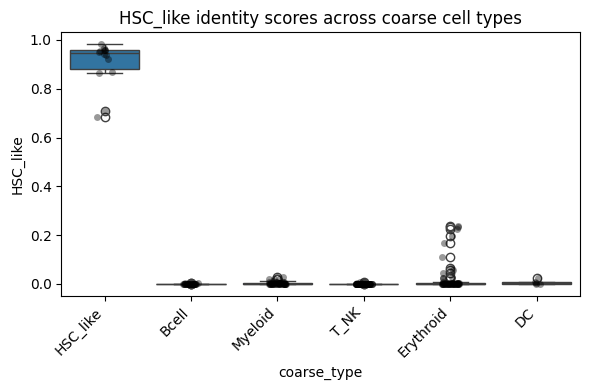

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.boxplot(data=results, x="coarse_type", y="HSC_like")
sns.stripplot(data=results, x="coarse_type", y="HSC_like", color="black", alpha=0.4)
plt.title("HSC_like identity scores across coarse cell types")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


/Users/travishong/miniforge3/envs/hema-cellnet-lite/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


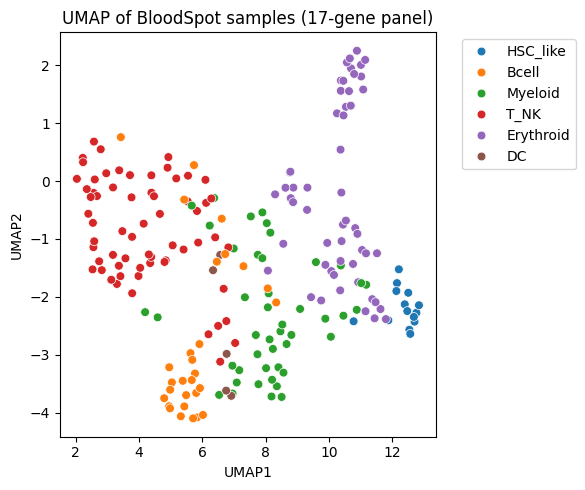

In [ ]:
from umap import UMAP
from sklearn.preprocessing import StandardScaler

umap = UMAP(n_neighbors=15, min_dist=0.3, random_state=42)
emb = umap.fit_transform(X_scaled)

umap_df = pd.DataFrame({
    "UMAP1": emb[:, 0],
    "UMAP2": emb[:, 1],
    "coarse_type": df["coarse_type"].values
})

plt.figure(figsize=(6,5))
sns.scatterplot(
    data=umap_df,
    x="UMAP1",
    y="UMAP2",
    hue="coarse_type",
    s=40
)
plt.title("UMAP of BloodSpot samples (17-gene panel)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [18]:
import joblib

joblib.dump(
    {
        "clf": clf,
        "scaler": scaler,
        "gene_cols": gene_cols,
        "classes": clf.classes_.tolist()
    },
    "../data/hema_small_panel_coarse_model.joblib"
)


['../data/hema_small_panel_coarse_model.joblib']

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/bloodspot_small_panel.tsv", sep="\t")

df.head()
df.shape


(211, 19)

In [2]:
gene_cols = [c for c in df.columns if c not in ["sample", "cell_type"]]
X = df[gene_cols].copy()

y = df["cell_type"].copy()

X.shape, y.shape


((211, 17), (211,))

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled.shape

(211, 17)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape

((168, 17), (43, 17))

In [6]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    multi_class="multinomial",
    max_iter=3000,
    C=1.0
)

clf.fit(X_train, y_train)

/Users/travishong/miniforge3/envs/hema-cellnet-lite/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,3000
,multi_class,'multinomial'


In [7]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

                         precision    recall  f1-score   support

        HSC CD38- CD34+       1.00      1.00      1.00         1
B-cell class can switch       0.00      0.00      0.00         1
  B-cell class switched       0.50      1.00      0.67         1
                B-cells       0.00      0.00      0.00         1
              Basophils       0.50      1.00      0.67         1
              CD4+Centr       0.00      0.00      0.00         1
              CD4+Effec       0.00      0.00      0.00         1
              CD8+Centr       0.00      0.00      0.00         2
              CD8+Effec       0.50      0.50      0.50         2
            CFU-Granulo       1.00      1.00      1.00         1
          CFU-Megakaryo       0.00      0.00      0.00         1
               CFU-Mono       1.00      1.00      1.00         1
                    CMP       0.00      0.00      0.00         1
           Early B-cell       0.00      0.00      0.00         1
            Eosinophill 

/Users/travishong/miniforge3/envs/hema-cellnet-lite/lib/python3.11/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
/Users/travishong/miniforge3/envs/hema-cellnet-lite/lib/python3.11/site-packages/sklearn/metrics/_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(y_pred, input_name="y_pred")
/Users/travishong/miniforge3/envs/hema-cellnet-lite/lib/python3.11/site-packages/sklearn/utils/multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  ys_types = set(type_of_target(x) for x in ys)
/Us

In [8]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X_scaled, y, cv=5)
print("CV accuracy:", scores.mean(), "+/-", scores.std())

CV accuracy: 0.5362126245847176 +/- 0.08634224177189397


/Users/travishong/miniforge3/envs/hema-cellnet-lite/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/travishong/miniforge3/envs/hema-cellnet-lite/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/travishong/miniforge3/envs/hema-cellnet-lite/lib/python3.11/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
/Users/travishong/miniforge3/envs/hema-cellnet-lite/lib/python3.11/site-packages/sklearn/linear_model/_l

In [9]:
import joblib

joblib.dump(
    {
        "clf": clf,
        "scaler": scaler,
        "gene_cols": gene_cols,
        "classes": clf.classes_.tolist()
    },
    "../data/hema_small_panel_model.joblib"
)


['../data/hema_small_panel_model.joblib']

In [12]:
# Make sure no weird spaces
df["cell_type"] = df["cell_type"].astype(str).str.strip()

# Rebuild coarse_type with the mapping we wrote
mapping = {}

HSC_like = ['HSC CD38- CD34+', 'HSC CD133+ CD34dim']
Erythroid = ['Eryth', 'MEP', 'CFU-Megakaryo', 'Megakaryocyte']
Myeloid = [
    'CFU-Granulo', 'CFU-Mono', 'CMP', 'Granulo (Neutro)', 'Gran',
    'Monocyte', 'Basophils', 'Eosinophill', 'Myeloid DC'
]
Bcell = [
    'B-cell class can switch', 'B-cell class switched', 'B-cells',
    'Naive B-cells', 'Early B-cell', 'Pro B-cell'
]
T_NK = [
    'CD4+Centr', 'CD4+Effec', 'CD8+Centr', 'CD8+Effec',
    'Naive CD4+ T-cell', 'Naive CD8+ T-cell',
    'NK CD56+CD16+', 'NK CD56-CD16+', 'NK CD56-CD16-', 'NKT'
]
DC = ['Plasmacytoid DC']

for ct in HSC_like:
    mapping[ct] = 'HSC_like'
for ct in Erythroid:
    mapping[ct] = 'Erythroid'
for ct in Myeloid:
    mapping[ct] = 'Myeloid'
for ct in Bcell:
    mapping[ct] = 'Bcell'
for ct in T_NK:
    mapping[ct] = 'T_NK'
for ct in DC:
    mapping[ct] = 'DC'

df["coarse_type"] = df["cell_type"].map(mapping)

# Show which types did NOT get mapped
unmapped = df[df["coarse_type"].isna()]["cell_type"].value_counts()
print(unmapped)


cell_type
GMP    4
Name: count, dtype: int64
